In [1]:
# 首先导入包
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
import math
from torch.nn import functional as F
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.nn import GCNConv

In [2]:
data = pd.read_csv("TripData_cleaned.csv")
data = data.drop('Unnamed: 0', axis=1)

data.head()

,lpep_pickup_datetime,Lpep_dropoff_datetime,Passenger_count,Trip_distance,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Total_amount,Trip_duration,Pickup_time,Speed,Pickup_cluster,Dropoff_cluster,year,month,day,time_span
0,2015-04-01 00:00:00,2015/4/1 0:08,1,3.08,-73.958817,40.716824,-73.982971,40.696007,14.76,8.0,1.427818e+09,23.100000,7,25,2015,4,1,0
1,2015-04-01 00:00:00,2015/4/1 0:07,1,1.21,-73.937531,40.804501,-73.946800,40.815998,8.30,7.0,1.427818e+09,10.371429,11,11,2015,4,1,0
2,2015-04-01 00:00:00,2015/4/1 0:02,1,0.64,-73.955818,40.681152,-73.955406,40.687145,6.00,2.0,1.427818e+09,19.200000,0,18,2015,4,1,0
3,2015-04-01 00:00:00,2015/4/1 0:05,1,1.34,-73.830551,40.759460,-73.825363,40.741589,7.80,5.0,1.427818e+09,16.080000,20,20,2015,4,1,0
4,2015-04-01 00:00:00,2015/4/1 0:05,1,0.98,-73.912086,40.775356,-73.915474,40.764091,7.30,5.0,1.427818e+09,11.760000,17,19,2015,4,1,0


In [3]:
# 根据指定的列进行分组，并对Passenger_count进行求和
grouped_data = data.groupby(['year', 'month', 'day', 'time_span', 'Pickup_cluster','Dropoff_cluster']).agg(
    {'Passenger_count': 'sum'}).reset_index()
# 将列名 'time_span' 修改为 'hour'
grouped_data = grouped_data.rename(columns={'time_span': 'hour'})

# 初始化 MinMaxScaler
scaler = MinMaxScaler()

# 因此我们使用 .values.reshape(-1, 1) 转换 Pickup_cluster 列
grouped_data['Passenger_count'] = scaler.fit_transform(grouped_data[['Passenger_count']])

grouped_data.head()

,year,month,day,hour,Pickup_cluster,Dropoff_cluster,Passenger_count
0,2015,4,1,0,0,0,0.028261
1,2015,4,1,0,0,7,0.010870
2,2015,4,1,0,0,10,0.015217
3,2015,4,1,0,0,11,0.002174
4,2015,4,1,0,0,12,0.019565


In [4]:
# 获取所有独特的cluster
all_clusters = np.union1d(grouped_data['Pickup_cluster'].unique(), grouped_data['Dropoff_cluster'].unique())

# 初始化存储所有图的字典
graphs = []
features = []

# 遍历每个独特的年月日小时组合
for (year, month, day, hour), group in grouped_data.groupby(['year', 'month', 'day', 'hour']):
    # 初始化图矩阵
    graph_matrix = np.zeros((len(all_clusters), len(all_clusters)))

    # 填充图矩阵
    for _, row in group.iterrows():
        pickup_idx = np.where(all_clusters == row['Pickup_cluster'])[0][0]
        dropoff_idx = np.where(all_clusters == row['Dropoff_cluster'])[0][0]
        graph_matrix[pickup_idx, dropoff_idx] = row['Passenger_count']

    features_list = []
    for i in range(len(graph_matrix)):
        temp_features = []
        temp_features.append(year)
        temp_features.append(month)
        temp_features.append(day)
        temp_features.append(hour)
        temp_features.append(graph_matrix[i].sum())
        features_list.append(temp_features)
    features.append(features_list)
    # 将图矩阵添加到字典
    graphs.append(graph_matrix)

In [5]:
graphs = np.array(graphs)
features = np.array(features)

In [6]:
graphs.shape

(449, 30, 30)

In [7]:
graphs

array([[[0.02826087, 0.        , 0.        , ..., 0.        ,
         0.        , 0.00217391],
        [0.        , 0.05434783, 0.00217391, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.17826087, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.01304348,
         0.        , 0.        ],
        [0.        , 0.00217391, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.00217391, 0.        , 0.        , ..., 0.00217391,
         0.        , 0.00434783]],

       [[0.02608696, 0.        , 0.        , ..., 0.00652174,
         0.        , 0.00217391],
        [0.        , 0.02608696, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.00217391, 0.12826087, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00434783,
         0.        , 0.        ],
        [0. 

In [8]:
class TripData(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [9]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3,4] # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

In [10]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss() # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    optimizer=torch.optim.Adam(model.parameters(),lr=config['learning_rate'],betas=(0.5,0.999))

    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)           
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Test loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/Test', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 20010106,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'test_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.            
    'batch_size': 16, 
    'learning_rate': 5e-5,              
    'early_stop': 50,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/GCNLSTM.ckpt'  # Your model will be saved here.
}

In [12]:
print(f"len(graphs):{len(graphs)}")

len(graphs):449


In [13]:
def split_data(data,time_step=24):
    dataX=[]
    datay=[]
    dataNew = []
    for i in range(len(data)-time_step):
        dataX.append(data[i:i+time_step])
        datay.append(data[i+time_step])
        dataNew.append(data[i:i+time_step+1])
    dataX=np.array(dataX).reshape(len(dataX),time_step,-1)
    datay=np.array(datay)
    dataNew=np.array(dataNew).reshape(len(dataNew),time_step+1,-1)
    return dataX,datay,dataNew

In [14]:
dataX,datay, dataNew=split_data(graphs)
print(f"dataX.shape:{dataX.shape},datay.shape:{datay.shape},dataNew.shape:{dataNew.shape}")

dataX.shape:(425, 24, 900),datay.shape:(425, 30, 30),dataNew.shape:(425, 25, 900)


In [15]:
# 计算验证集的大小（后10%的数据）
valid_size = int(len(dataNew) * 0.1)

# 从数据集的末尾取后10%作为验证集
valid_data = dataNew[-valid_size:]

In [16]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_test_split(data_set, test_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(test_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [17]:
train_data, test_data = train_test_split(dataNew, config['test_ratio'], config['seed'])

# Select features
x_train, x_test, y_train, y_test = train_data[:,:-1], test_data[:,:-1], train_data[:,-1], test_data[:,-1],

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

len(train_data)

number of features: 24


340

In [18]:
train_dataset, valid_dataset = TripData(x_train, y=y_train), TripData(x_test, y=y_test),

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

In [19]:
# 定义输入、隐藏状态和输出维度
input_size = dataNew.shape[2]  # 输入特征维度
hidden_size = 256  # LSTM隐藏状态维度
num_layers = 8  # LSTM层数
output_size = dataNew.shape[2]  # 输出维度（预测目标维度）

In [20]:
def compute_laplacian_and_add(A):
    # 计算邻接矩阵
    adjacency_matrix = (A > 0).float()

    # 计算度矩阵
    degree = torch.sum(adjacency_matrix, dim=1)
    D = torch.diag(degree)

    # 计算拉普拉斯矩阵
    L = D - adjacency_matrix

    # 计算标准化对称拉普拉斯矩阵
    D_inv_sqrt = torch.pow(D, -0.5)
    D_inv_sqrt[D_inv_sqrt == float('inf')] = 0
    L_sym = torch.matmul(D_inv_sqrt, torch.matmul(L, D_inv_sqrt))

    # 将 L_sym 与 A 相加
    result = L_sym + A
    
    return result

In [21]:
class GCN_LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GCN_LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.to(device)
        M, N, _ = x.size()
        x = x.reshape(M, N, 30, 30)
        x_sym = torch.zeros_like(x).to(x.device)

        for j in range(M):
            for i in range(N):
                A = x[j][i]
                x_sym[j][i] = compute_laplacian_and_add(A)
        
        x = x_sym.reshape(M, N, 900)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [22]:
model = GCN_LSTM_model(input_size, hidden_size, num_layers, output_size).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/500]: 100%|██████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.87it/s, loss=0.0016]


Epoch [1/500]: Train loss: 0.0019, Test loss: 0.0016
Saving model with loss 0.002...


Epoch [2/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.38it/s, loss=0.000884]


Epoch [2/500]: Train loss: 0.0012, Test loss: 0.0007
Saving model with loss 0.001...


Epoch [3/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.17it/s, loss=0.000267]


Epoch [3/500]: Train loss: 0.0005, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [4/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.69it/s, loss=0.000437]


Epoch [4/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [5/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.67it/s, loss=0.00019]


Epoch [5/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [6/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.03it/s, loss=0.000213]


Epoch [6/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [7/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.05it/s, loss=0.000233]


Epoch [7/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [8/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.53it/s, loss=0.000329]


Epoch [8/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [9/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.59it/s, loss=0.000175]


Epoch [9/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [10/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.69it/s, loss=0.000264]


Epoch [10/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [11/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.41it/s, loss=0.000476]


Epoch [11/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [12/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.43it/s, loss=0.000198]


Epoch [12/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [13/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.54it/s, loss=0.00025]


Epoch [13/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [14/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.61it/s, loss=0.000401]


Epoch [14/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [15/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.31it/s, loss=0.000498]


Epoch [15/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [16/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.85it/s, loss=0.00069]


Epoch [16/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [17/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.72it/s, loss=0.00018]


Epoch [17/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [18/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.85it/s, loss=0.000205]


Epoch [18/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [19/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.48it/s, loss=0.00017]


Epoch [19/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [20/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.35it/s, loss=0.000299]


Epoch [20/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [21/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.92it/s, loss=0.000226]


Epoch [21/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [22/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.66it/s, loss=0.000547]


Epoch [22/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [23/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.05it/s, loss=0.00017]


Epoch [23/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [24/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.86it/s, loss=0.00026]


Epoch [24/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [25/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.48it/s, loss=0.000147]


Epoch [25/500]: Train loss: 0.0003, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [26/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.11it/s, loss=0.000291]


Epoch [26/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [27/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.15it/s, loss=0.000202]


Epoch [27/500]: Train loss: 0.0002, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [28/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.17it/s, loss=0.000607]


Epoch [28/500]: Train loss: 0.0003, Test loss: 0.0003


Epoch [29/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.46it/s, loss=0.000186]


Epoch [29/500]: Train loss: 0.0002, Test loss: 0.0003
Saving model with loss 0.000...


Epoch [30/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.28it/s, loss=0.000206]


Epoch [30/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [31/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.91it/s, loss=0.000169]


Epoch [31/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [32/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.01it/s, loss=0.000154]


Epoch [32/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [33/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.60it/s, loss=0.000139]


Epoch [33/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [34/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.24it/s, loss=0.00017]


Epoch [34/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [35/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.12it/s, loss=0.00018]


Epoch [35/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [36/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.10it/s, loss=0.00037]


Epoch [36/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [37/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.01it/s, loss=8.76e-5]


Epoch [37/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [38/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.92it/s, loss=0.000165]


Epoch [38/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [39/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.48it/s, loss=0.000137]


Epoch [39/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [40/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.40it/s, loss=0.000156]


Epoch [40/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [41/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.96it/s, loss=0.00018]


Epoch [41/500]: Train loss: 0.0002, Test loss: 0.0002


Epoch [42/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.39it/s, loss=0.000163]


Epoch [42/500]: Train loss: 0.0002, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [43/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.66it/s, loss=0.000152]


Epoch [43/500]: Train loss: 0.0001, Test loss: 0.0002
Saving model with loss 0.000...


Epoch [44/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.18it/s, loss=9.01e-5]


Epoch [44/500]: Train loss: 0.0001, Test loss: 0.0002


Epoch [45/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.65it/s, loss=0.000144]


Epoch [45/500]: Train loss: 0.0001, Test loss: 0.0002


Epoch [46/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.29it/s, loss=0.000111]


Epoch [46/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [47/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.70it/s, loss=0.000187]


Epoch [47/500]: Train loss: 0.0001, Test loss: 0.0002


Epoch [48/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.34it/s, loss=0.00019]


Epoch [48/500]: Train loss: 0.0001, Test loss: 0.0002


Epoch [49/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.32it/s, loss=0.000153]


Epoch [49/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [50/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.59it/s, loss=7.05e-5]


Epoch [50/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [51/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.04it/s, loss=0.000121]


Epoch [51/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [52/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.43it/s, loss=7.29e-5]


Epoch [52/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [53/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.82it/s, loss=7.52e-5]


Epoch [53/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [54/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.27it/s, loss=9.56e-5]


Epoch [54/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [55/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.47it/s, loss=7.26e-5]


Epoch [55/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [56/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.07it/s, loss=0.000114]


Epoch [56/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [57/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.99it/s, loss=0.000153]


Epoch [57/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [58/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.64it/s, loss=0.000118]


Epoch [58/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [59/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.90it/s, loss=0.000136]


Epoch [59/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [60/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.57it/s, loss=8.21e-5]


Epoch [60/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [61/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.04it/s, loss=8.7e-5]


Epoch [61/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [62/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.62it/s, loss=6.25e-5]


Epoch [62/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [63/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.82it/s, loss=0.000103]


Epoch [63/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [64/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.53it/s, loss=6.38e-5]


Epoch [64/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [65/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.80it/s, loss=9.06e-5]


Epoch [65/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [66/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.46it/s, loss=0.000114]


Epoch [66/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [67/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.64it/s, loss=0.000121]


Epoch [67/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [68/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.20it/s, loss=0.000115]


Epoch [68/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [69/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.07it/s, loss=9.23e-5]


Epoch [69/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [70/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.87it/s, loss=0.000104]


Epoch [70/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [71/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.21it/s, loss=0.000109]


Epoch [71/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [72/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.25it/s, loss=7.78e-5]


Epoch [72/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [73/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.13it/s, loss=6.9e-5]


Epoch [73/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [74/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.26it/s, loss=7.69e-5]


Epoch [74/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [75/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.15it/s, loss=9.32e-5]


Epoch [75/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [76/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.69it/s, loss=7.72e-5]


Epoch [76/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [77/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.09it/s, loss=4.13e-5]


Epoch [77/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [78/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.09it/s, loss=5.15e-5]


Epoch [78/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [79/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.32it/s, loss=6.98e-5]


Epoch [79/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [80/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.46it/s, loss=4.57e-5]


Epoch [80/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [81/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.49it/s, loss=9.92e-5]


Epoch [81/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [82/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.91it/s, loss=4.65e-5]


Epoch [82/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [83/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.76it/s, loss=7.33e-5]


Epoch [83/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [84/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.77it/s, loss=0.000102]


Epoch [84/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [85/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.89it/s, loss=7.1e-5]


Epoch [85/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [86/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.53it/s, loss=6.37e-5]


Epoch [86/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [87/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.65it/s, loss=6.88e-5]


Epoch [87/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [88/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.91it/s, loss=8.67e-5]


Epoch [88/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [89/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.75it/s, loss=6.28e-5]


Epoch [89/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [90/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.15it/s, loss=0.000138]


Epoch [90/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [91/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.84it/s, loss=7.38e-5]


Epoch [91/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [92/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.68it/s, loss=3.28e-5]


Epoch [92/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [93/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.91it/s, loss=7.3e-5]


Epoch [93/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [94/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.08it/s, loss=8.47e-5]


Epoch [94/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [95/500]: 100%|█████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.07it/s, loss=9.9e-5]


Epoch [95/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [96/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.26it/s, loss=9.34e-5]


Epoch [96/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [97/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.91it/s, loss=4.93e-5]


Epoch [97/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [98/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.81it/s, loss=9.44e-5]


Epoch [98/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [99/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.51it/s, loss=5.07e-5]


Epoch [99/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [100/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.13it/s, loss=6.53e-5]


Epoch [100/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [101/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.13it/s, loss=0.000106]


Epoch [101/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [102/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.15it/s, loss=4.38e-5]


Epoch [102/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [103/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.05it/s, loss=0.00011]


Epoch [103/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [104/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.47it/s, loss=5.36e-5]


Epoch [104/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [105/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.84it/s, loss=0.000105]


Epoch [105/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [106/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.02it/s, loss=2.48e-5]


Epoch [106/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [107/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.73it/s, loss=6.07e-5]


Epoch [107/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [108/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.84it/s, loss=7.43e-5]


Epoch [108/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [109/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.26it/s, loss=3.5e-5]


Epoch [109/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [110/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.87it/s, loss=7.51e-5]


Epoch [110/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [111/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.19it/s, loss=5.75e-5]


Epoch [111/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [112/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.61it/s, loss=6.08e-5]


Epoch [112/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [113/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.59it/s, loss=7.51e-5]


Epoch [113/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [114/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.61it/s, loss=9.85e-5]


Epoch [114/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [115/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.25it/s, loss=5.64e-5]


Epoch [115/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [116/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.49it/s, loss=5.12e-5]


Epoch [116/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [117/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  7.07it/s, loss=7.03e-5]


Epoch [117/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [118/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.57it/s, loss=5.21e-5]


Epoch [118/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [119/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.11it/s, loss=6.86e-5]


Epoch [119/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [120/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.55it/s, loss=8.79e-5]


Epoch [120/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [121/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.79it/s, loss=7.07e-5]


Epoch [121/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [122/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.55it/s, loss=4.1e-5]


Epoch [122/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [123/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.86it/s, loss=4.65e-5]


Epoch [123/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [124/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.85it/s, loss=6.07e-5]


Epoch [124/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [125/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.46it/s, loss=8.41e-5]


Epoch [125/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [126/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.08it/s, loss=5.07e-5]


Epoch [126/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [127/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.40it/s, loss=5.05e-5]


Epoch [127/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [128/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.09it/s, loss=4.51e-5]


Epoch [128/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [129/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.13it/s, loss=3.93e-5]


Epoch [129/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [130/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.62it/s, loss=5.55e-5]


Epoch [130/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [131/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.11it/s, loss=6.03e-5]


Epoch [131/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [132/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.24it/s, loss=9.04e-5]


Epoch [132/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [133/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.24it/s, loss=5.58e-5]


Epoch [133/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [134/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.16it/s, loss=5.85e-5]


Epoch [134/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [135/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.13it/s, loss=5.65e-5]


Epoch [135/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [136/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.88it/s, loss=7.89e-5]


Epoch [136/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [137/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.13it/s, loss=8.61e-5]


Epoch [137/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [138/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.92it/s, loss=4.12e-5]


Epoch [138/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [139/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.69it/s, loss=3.92e-5]


Epoch [139/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [140/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.18it/s, loss=7.1e-5]


Epoch [140/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [141/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.82it/s, loss=4.98e-5]


Epoch [141/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [142/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.66it/s, loss=6.22e-5]


Epoch [142/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [143/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.10it/s, loss=3.81e-5]


Epoch [143/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [144/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.87it/s, loss=8.51e-5]


Epoch [144/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [145/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.03it/s, loss=7.82e-5]


Epoch [145/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [146/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.04it/s, loss=4.35e-5]


Epoch [146/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [147/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.62it/s, loss=3.96e-5]


Epoch [147/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [148/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.34it/s, loss=5.07e-5]


Epoch [148/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [149/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.34it/s, loss=8.2e-5]


Epoch [149/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [150/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.39it/s, loss=2.65e-5]


Epoch [150/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [151/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.13it/s, loss=6.07e-5]


Epoch [151/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [152/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.30it/s, loss=9.47e-5]


Epoch [152/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [153/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.82it/s, loss=7.11e-5]


Epoch [153/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [154/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.98it/s, loss=7.51e-5]


Epoch [154/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [155/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.57it/s, loss=5.96e-5]


Epoch [155/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [156/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.17it/s, loss=7.55e-5]


Epoch [156/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [157/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.28it/s, loss=6.99e-5]


Epoch [157/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [158/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.02it/s, loss=5.3e-5]


Epoch [158/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [159/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.88it/s, loss=6.95e-5]


Epoch [159/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [160/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.72it/s, loss=4.06e-5]


Epoch [160/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [161/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.62it/s, loss=8.52e-5]


Epoch [161/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [162/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.82it/s, loss=7.24e-5]


Epoch [162/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [163/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.29it/s, loss=5.41e-5]


Epoch [163/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [164/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.15it/s, loss=0.0001]


Epoch [164/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [165/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.95it/s, loss=5.96e-5]


Epoch [165/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [166/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.73it/s, loss=3.29e-5]


Epoch [166/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [167/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.29it/s, loss=6.38e-5]


Epoch [167/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [168/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.13it/s, loss=5.97e-5]


Epoch [168/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [169/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.45it/s, loss=7.85e-5]


Epoch [169/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [170/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.19it/s, loss=7.32e-5]


Epoch [170/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [171/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.89it/s, loss=4.78e-5]


Epoch [171/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [172/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.11it/s, loss=5.02e-5]


Epoch [172/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [173/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.37it/s, loss=7.1e-5]


Epoch [173/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [174/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.93it/s, loss=6.94e-5]


Epoch [174/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [175/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.92it/s, loss=5.96e-5]


Epoch [175/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [176/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.29it/s, loss=4.54e-5]


Epoch [176/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [177/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.22it/s, loss=3.22e-5]


Epoch [177/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [178/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.04it/s, loss=5.25e-5]


Epoch [178/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [179/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.25it/s, loss=8.04e-5]


Epoch [179/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [180/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.07it/s, loss=8.43e-5]


Epoch [180/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [181/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.97it/s, loss=6.81e-5]


Epoch [181/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [182/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.26it/s, loss=7.35e-5]


Epoch [182/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [183/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.15it/s, loss=6.28e-5]


Epoch [183/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [184/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.67it/s, loss=2.4e-5]


Epoch [184/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [185/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.96it/s, loss=1.4e-5]


Epoch [185/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [186/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.75it/s, loss=6.84e-5]


Epoch [186/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [187/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.45it/s, loss=6.01e-5]


Epoch [187/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [188/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.26it/s, loss=4.09e-5]


Epoch [188/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [189/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.23it/s, loss=5.56e-5]


Epoch [189/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [190/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  7.17it/s, loss=5.03e-5]


Epoch [190/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [191/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.61it/s, loss=6.65e-5]


Epoch [191/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [192/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.42it/s, loss=6.71e-5]


Epoch [192/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [193/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.80it/s, loss=4.02e-5]


Epoch [193/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [194/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.48it/s, loss=6.52e-5]


Epoch [194/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [195/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.93it/s, loss=3.99e-5]


Epoch [195/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [196/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.19it/s, loss=3.79e-5]


Epoch [196/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [197/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.95it/s, loss=3.78e-5]


Epoch [197/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [198/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.06it/s, loss=3.87e-5]


Epoch [198/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [199/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.08it/s, loss=5.17e-5]


Epoch [199/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [200/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.36it/s, loss=3.51e-5]


Epoch [200/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [201/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.74it/s, loss=4.56e-5]


Epoch [201/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [202/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.87it/s, loss=2.25e-5]


Epoch [202/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [203/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.57it/s, loss=4.39e-5]


Epoch [203/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [204/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.15it/s, loss=5.11e-5]


Epoch [204/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [205/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.12it/s, loss=5.08e-5]


Epoch [205/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [206/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.45it/s, loss=8.04e-5]


Epoch [206/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [207/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.64it/s, loss=7.25e-5]


Epoch [207/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [208/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.45it/s, loss=6.11e-5]


Epoch [208/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [209/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.73it/s, loss=6.66e-5]


Epoch [209/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [210/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.78it/s, loss=6.82e-5]


Epoch [210/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [211/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.53it/s, loss=4.5e-5]


Epoch [211/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [212/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.44it/s, loss=8.4e-5]


Epoch [212/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [213/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.41it/s, loss=4.48e-5]


Epoch [213/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [214/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.68it/s, loss=5.49e-5]


Epoch [214/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [215/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.52it/s, loss=4.01e-5]


Epoch [215/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [216/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.68it/s, loss=5.52e-5]


Epoch [216/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [217/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.59it/s, loss=6.39e-5]


Epoch [217/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [218/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.42it/s, loss=4.83e-5]


Epoch [218/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [219/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.05it/s, loss=5.61e-5]


Epoch [219/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [220/500]: 100%|██████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.40it/s, loss=0.000102]


Epoch [220/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [221/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.70it/s, loss=6.23e-5]


Epoch [221/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [222/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.29it/s, loss=5.14e-5]


Epoch [222/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [223/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.62it/s, loss=6.7e-5]


Epoch [223/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [224/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.67it/s, loss=5.1e-5]


Epoch [224/500]: Train loss: 0.0001, Test loss: 0.0001
Saving model with loss 0.000...


Epoch [225/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.59it/s, loss=5.84e-5]


Epoch [225/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [226/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.16it/s, loss=4.52e-5]


Epoch [226/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [227/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.17it/s, loss=6.17e-5]


Epoch [227/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [228/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.20it/s, loss=5.58e-5]


Epoch [228/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [229/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.68it/s, loss=5.34e-5]


Epoch [229/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [230/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.69it/s, loss=6.37e-5]


Epoch [230/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [231/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.34it/s, loss=5.52e-5]


Epoch [231/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [232/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.75it/s, loss=6.07e-5]


Epoch [232/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [233/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.54it/s, loss=7.98e-5]


Epoch [233/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [234/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.82it/s, loss=4.38e-5]


Epoch [234/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [235/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.55it/s, loss=6.12e-5]


Epoch [235/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [236/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.80it/s, loss=4.81e-5]


Epoch [236/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [237/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.54it/s, loss=6.1e-5]


Epoch [237/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [238/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.10it/s, loss=5.38e-5]


Epoch [238/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [239/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.19it/s, loss=6.93e-5]


Epoch [239/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [240/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.99it/s, loss=3.92e-5]


Epoch [240/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [241/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.56it/s, loss=4.39e-5]


Epoch [241/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [242/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.31it/s, loss=4.49e-5]


Epoch [242/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [243/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.18it/s, loss=6.15e-5]


Epoch [243/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [244/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.65it/s, loss=7.99e-5]


Epoch [244/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [245/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.31it/s, loss=5.18e-5]


Epoch [245/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [246/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.57it/s, loss=2.87e-5]


Epoch [246/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [247/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.98it/s, loss=4.49e-5]


Epoch [247/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [248/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.24it/s, loss=5.4e-5]


Epoch [248/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [249/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.79it/s, loss=5.16e-5]


Epoch [249/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [250/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.83it/s, loss=7.04e-5]


Epoch [250/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [251/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.20it/s, loss=3.06e-5]


Epoch [251/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [252/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.45it/s, loss=3.2e-5]


Epoch [252/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [253/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.92it/s, loss=5.16e-5]


Epoch [253/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [254/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.93it/s, loss=6.07e-5]


Epoch [254/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [255/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.36it/s, loss=6.1e-5]


Epoch [255/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [256/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.56it/s, loss=4.34e-5]


Epoch [256/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [257/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.85it/s, loss=5.09e-5]


Epoch [257/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [258/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.57it/s, loss=4.71e-5]


Epoch [258/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [259/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.47it/s, loss=5.09e-5]


Epoch [259/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [260/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.33it/s, loss=5.43e-5]


Epoch [260/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [261/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.72it/s, loss=5.65e-5]


Epoch [261/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [262/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.40it/s, loss=5.56e-5]


Epoch [262/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [263/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.08it/s, loss=7.36e-5]


Epoch [263/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [264/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.12it/s, loss=5.34e-5]


Epoch [264/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [265/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.00it/s, loss=7.53e-5]


Epoch [265/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [266/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.21it/s, loss=7.19e-5]


Epoch [266/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [267/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.64it/s, loss=4.9e-5]


Epoch [267/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [268/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.42it/s, loss=3.91e-5]


Epoch [268/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [269/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:04<00:00,  5.17it/s, loss=6.41e-5]


Epoch [269/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [270/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.96it/s, loss=4.75e-5]


Epoch [270/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [271/500]: 100%|████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.63it/s, loss=4.9e-5]


Epoch [271/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [272/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.87it/s, loss=5.83e-5]


Epoch [272/500]: Train loss: 0.0001, Test loss: 0.0001


Epoch [273/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.46it/s, loss=3.34e-5]


Epoch [273/500]: Train loss: 0.0000, Test loss: 0.0001


Epoch [274/500]: 100%|███████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.78it/s, loss=6.19e-5]


Epoch [274/500]: Train loss: 0.0001, Test loss: 0.0001

Model is not improving, so we halt the training session.


In [23]:
model = GCN_LSTM_model(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load(config['save_path']))

<All keys matched successfully>

In [24]:
valid_dataset =  TripData(valid_data)
# valid_dataset =  TripData(train_data)

In [25]:
y_valid=valid_data[:,-1]
# y_valid=train_data[:,-1]

In [26]:
pred_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True)

In [27]:
preds = predict(pred_loader, model, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 63.17it/s]


In [28]:
y_valid_reshaped = np.sum(y_valid.reshape(42, 30, 30), axis=2)
# y_valid_reshaped = np.sum(y_valid.reshape(340, 30, 30), axis=2)

In [29]:
preds_reshaped = np.sum(preds.reshape(42, 30, 30), axis=2)
# preds_reshaped = np.sum(preds.reshape(340, 30, 30), axis=2)

In [30]:
# 从每个周期中提取第一个簇的乘客计数
y_valid_passenger_count = [cycle[0] for cycle in y_valid_reshaped]
preds_passenger_count = [cycle[0] for cycle in preds_reshaped]

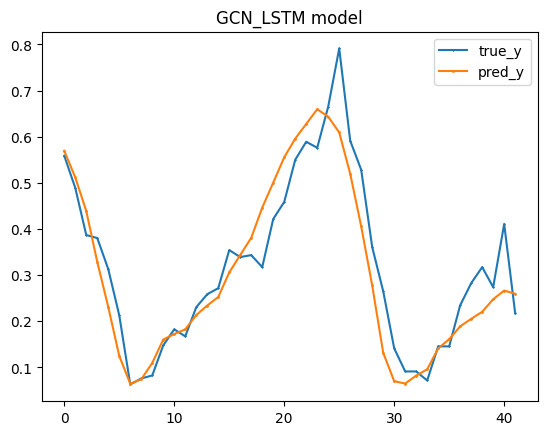

In [31]:
plt.title("GCN_LSTM model")
x=[i for i in range(len(y_valid))]
plt.plot(x,y_valid_passenger_count,marker="x",markersize=1,label="true_y")
plt.plot(x,preds_passenger_count,marker="o",markersize=1,label="pred_y")
plt.legend()
plt.show()

In [32]:
loss = 0
for i in range(len(y_valid)):
    loss += ((preds_passenger_count[i]-y_valid_passenger_count[i])**2)**0.5
    
print("总误差是{}".format(loss))

总误差是2.197232827997726
